In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from glob import glob

In [6]:
base_dir = "/root/vllm/benchmarks/result"
replace_name = {
    "fcfs": "FCFS",
    "las": "LAS",
    "srjf": "SRJF",
    "sjf": "SJF",
    "tfittradeoff": "TFITTradeoff",
    "sjmlfq":"SJMLFQ"
}

# Util functions


In [7]:
def add_num_annotation(ax, rotation=0, fontsize=10):
    for _p in ax.patches:
        if _p.get_height() == 0:
            continue
        ax.annotate(
            str(round(_p.get_height(), 2)),
            (_p.get_x() + _p.get_width() / 2.0, _p.get_height() * 1.05),
            ha="center",
            va="center",
            xytext=(0, 6),
            textcoords="offset points",
            rotation=rotation,
            fontsize=fontsize,
        )
def get_metric_ratio(df):
    min_result = df["Value"].min()
    df["Ratio"] = round(df["Value"] / 1,2)
    return df
def get_metric_ratio_result(df, columns):
    min_result = df[columns].min()
    df[columns] = round(df[columns] / 1,2)
    return df


def generate_dir_names(base_dir, dates, counters):
    """生成目录路径列表"""
    dir_names = []
    for date, counter_list in zip(dates, counters):
        dir_names.extend([os.path.join(base_dir, date, str(counter)) for counter in counter_list])
    return dir_names
def process_file(file_path, schedule_policies, qps, detailed):
    """处理单个文件并返回策略和 DataFrame"""
    if not file_path.endswith(".csv") or qps not in file_path:
        return None, None

    if not detailed and "_detailed" not in file_path:
        df = pd.read_csv(file_path)
        df["Cache Efficiency"] = df["Running"] / df["GPU KV cache usage"]
    elif  detailed and "_detailed" in file_path:
        df = pd.read_csv(file_path)
    else:
        return None, None

    for policy in schedule_policies:
        if policy in file_path:
            return policy.upper(), df
    return None, None


def load_execute_results(dir_names, schedule_policies,qps, detailed):
    """加载执行结果并返回字典"""
    execute_result_dfs = {}
    for dir_name in dir_names:
        for file_name in os.listdir(dir_name):
            file_path = os.path.join(dir_name, file_name)
            policy, df = process_file(file_path, schedule_policies,qps,detailed)
            if policy and df is not None:
                execute_result_dfs[policy] = df
    return execute_result_dfs


# E2E result Analysis

## load data from file

In [8]:
def single_gpu():
    dates = ['20250102','20250103',"20250105","20250106",'20250107']
    counters = [[348,350,353, 355,356, 358],[362,378,379,380],[418],[424,441],[449,450,454]]
    return dates, counters

def single_gpu_7():
    dates=['20250113']
    counters=[[555]]
    return dates, counters

def multi_gpu():
    dates = ['20250108', '20250109', '20250110','20250111','20250112']
    # # counters=[[474,479]]
    # counters=[[478],[486]]
    counters=[[478],[490,497,500],[506,507, 508,509, 510,511, 512,519,521],[524,528,531],[532,534, 535]]
    return dates, counters


# def multi_gpu_70b():
#     dates=['20250116','20250117','20250118','20250217','20250218','20250219','20250220']
#     counters=[[592],[592],[592],[802],[802],[814,817,818, 820],[826]]
#     return dates, counters  
def multi_gpu_70b():
    dates=['20250116','20250117','20250118','20250223','20250226','20250227','20250303']
    counters=[[592],[592],[592],[835],[841],[842,843],[863]]
    return dates, counters  

def multi_gpu_70b_pp():
    dates=['20250123','20250124',  '20250129','20250130', '20250212','20250216','20250217','20250']
    counters=[[687],[687],[699],[702],[710,712,716],[796],[796]]
    return dates, counters  
# counters = [[348,350,353, 355,356, 358, 359],[362, 377,378,379,380],[406,418],[424,441],[449,450]]
# counters = [[348,355,356, 358, 359],[360,377,378,379,384],[394]]

dates, counters = single_gpu()
# dates, counters = multi_gpu()
# dates,counters=single_gpu_7()
# dates, counters = multi_gpu_70b()
# dates, counters = multi_gpu_70b_pp()
e2e_result_dir_names = generate_dir_names(base_dir, dates, counters)

In [9]:
json_files = []
for dir_name in e2e_result_dir_names:
    json_files.extend(glob(os.path.join(dir_name, "*.json")))
e2e_result_dfs = {}
for file_path in json_files:
    with open(file_path, "r") as f:
        data = json.load(f)
    # 创建 DataFrame 并删除不需要的列
    e2e_result_df = pd.DataFrame(data).drop(
        columns=[
            "date",
            "backend",
            "tokenizer_id",
            "best_of",
            "use_beam_search",
        ]
    )
    # 替换 DataFrame 中的值
    e2e_result_df.replace(replace_name, inplace=True)
    
    # 将处理后的 DataFrame 存入字典
    file_name = os.path.basename(file_path)
    e2e_result_dfs[file_name] = e2e_result_df

## token Level result

### throughput

In [10]:
def extract_e2e_results(e2e_result_dfs):
    """从多个 DataFrame 中提取结果并返回一个聚合后的 DataFrame"""
    e2e_result = {
        "scheduling_policies": [],
        "request_throughput": [],
        "output_throughput": [],
        "request_rates": [],
    }

    for df_name, df in e2e_result_dfs.items():
        e2e_result["scheduling_policies"].append(df["scheduler_policy"].iloc[0])
        e2e_result["request_throughput"].append(df["request_throughput"].mean())
        e2e_result["output_throughput"].append(df["output_throughput"].mean())
        e2e_result["request_rates"].append(df["request_rate"].iloc[0])

    result_df = pd.DataFrame(e2e_result)

    # 按策略和请求率分组并取最大值
    result_df = (
        result_df.groupby(["scheduling_policies", "request_rates"])
        .mean()
        .reset_index()
    )

    # 计算吞吐量比率
    result_df = (
        result_df.groupby([ "request_rates"], group_keys=False)
        .apply(lambda row: get_metric_ratio_result(row, "output_throughput"))
    )

    return result_df

def plot_throughput(result_df, x, y, hue, ylabel, xlabel, ax):
    """绘制吞吐量柱状图"""
    sns.barplot(data=result_df, x=x, y=y, hue=hue, ax=ax, width=0.7)
    add_num_annotation(ax, rotation=90)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid(linestyle="--", alpha=0.5, axis="y")

def e2e_result():
    """主函数：处理数据并绘制图表"""
    # 提取并处理数据
    result_df = extract_e2e_results(e2e_result_dfs)

    # 设置绘图样式
    sns.set_style(style="whitegrid")
    sns.set_palette("deep")

    # 创建子图
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=150)

    # 绘制请求吞吐量图
    plot_throughput(
        result_df,
        x="request_rates",
        y="request_throughput",
        hue="scheduling_policies",
        ylabel="Throughput (requests/s)",
        xlabel="Request Rate (r/s)",
        ax=axes[0],
    )
    axes[0].legend(
        title="",
        frameon=False,
        ncol=3,
        loc=(0, 1),
        handlelength=1.0,
        columnspacing=0.5,
    )

    # 绘制输出吞吐量图
    plot_throughput(
        result_df,
        x="request_rates",
        y="output_throughput",
        hue="scheduling_policies",
        ylabel="Throughput (Token/s)",
        xlabel="Request Rate (r/s)",
        ax=axes[1],
    )

    # 显示图表
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_806519/1058433496.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio_result(row, "output_throughput"))


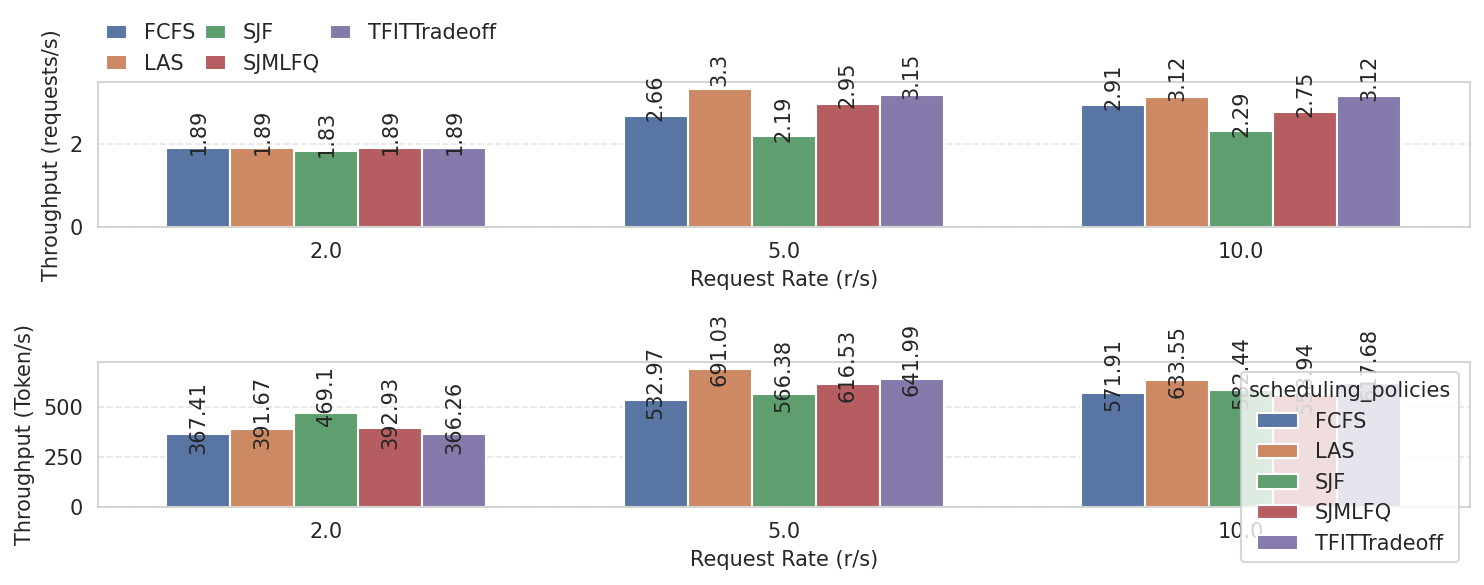

In [11]:
e2e_result()

### TPOT & TTFT

In [12]:
def extract_selected_results(e2e_result_dfs):
    """从多个 DataFrame 中提取特定列的数据"""
    selected_result = {
        "scheduler_policy": [],
        "swap_policy": [],
        "request_rate": [],
    }
    selected_columns = [
        "mean_ttft_ms", "median_ttft_ms", "p99_ttft_ms",
        "mean_tpot_ms", "median_tpot_ms", "p99_tpot_ms",
        "mean_itl_ms", "median_itl_ms", "p99_itl_ms",
        "mean_lat_ms", "median_lat_ms", "p99_lat_ms",
    ]

    # 初始化 selected_columns 的值为空列表
    for column in selected_columns:
        selected_result[column] = []

    # 遍历每个 DataFrame 并提取数据
    for df_name, df in e2e_result_dfs.items():
        # 提取策略和请求率
        selected_result["scheduler_policy"].append(df["scheduler_policy"].iloc[0])
        selected_result["swap_policy"].append(df["swap_policy"].iloc[0])
        selected_result["request_rate"].append(df["request_rate"].iloc[0])

        # 提取选定的列数据
        for column in selected_columns:
            if column in df.columns:
                if pd.api.types.is_numeric_dtype(df[column]):
                    selected_result[column].append(df[column].min())
                else:
                    selected_result[column].append(df[column].iloc[0])
            else:
                selected_result[column].append(None)  # 如果列不存在，填充为 None

    return selected_result, selected_columns

selected_result,selected_columns = extract_selected_results(e2e_result_dfs)

In [13]:
def process_selected_result(selected_result, selected_columns):
    """处理 selected_result 并返回长格式的 DataFrame"""
    # 转换为 DataFrame
    result_df = pd.DataFrame(selected_result)

    # 按策略和请求率分组并计算均值
    result_df = (
        result_df.groupby(["scheduler_policy", "swap_policy", "request_rate"])
        .mean()
        .reset_index()
    )

    # 选择需要的列并转换为长格式
    long_df = result_df[
        ["scheduler_policy", "swap_policy", "request_rate"] + selected_columns
    ].melt(
        id_vars=["scheduler_policy", "swap_policy", "request_rate"],
        value_vars=selected_columns,
        var_name="Metric",
        value_name="Value",
    )

    # 计算指标比率（假设 get_metric_ratio 是一个自定义函数）
    long_df = (
        long_df.groupby(["Metric", "request_rate"], group_keys=False)
        .apply(lambda row: get_metric_ratio(row))
        .reset_index()
    )

    # 拆分 Metric 列
    long_df[["metric_name", "metric_type"]] = long_df["Metric"].apply(
        lambda row: pd.Series(
            [row.split("_", 2)[0].capitalize(), row.split("_", 2)[1].upper()]
        )
    )

    return long_df

selected_columns = [
    "mean_ttft_ms", "median_ttft_ms", "p99_ttft_ms",
    "mean_tpot_ms", "median_tpot_ms", "p99_tpot_ms",
    "mean_itl_ms", "median_itl_ms", "p99_itl_ms",
    "mean_lat_ms", "median_lat_ms", "p99_lat_ms",
]
long_df = process_selected_result(selected_result, selected_columns)


/tmp/ipykernel_806519/1478430584.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio(row))


In [14]:
def plot_bar(_long_df, required_metric_name_list, required_metric_type_list):
    """绘制柱状图"""
    # 过滤数据
    _long_df = _long_df[
        (
            (_long_df["metric_name"] == required_metric_name_list[0])
            & (_long_df["metric_type"] == required_metric_type_list[0])
        )
        | (
            (_long_df["metric_name"] == required_metric_name_list[0])
            & (_long_df["metric_type"] == required_metric_type_list[1])
        )
        | (
            (_long_df["metric_name"] == required_metric_name_list[1])
            & (_long_df["metric_type"] == required_metric_type_list[0])
        )
        | (
            (_long_df["metric_name"] == required_metric_name_list[1])
            & (_long_df["metric_type"] == required_metric_type_list[1])
        )
    ]
    # 创建子图
    fig, ax = plt.subplots(figsize=(4 * 2, 2 * 2), dpi=150, nrows=2, ncols=2)
    metrics = [
        (required_metric_name_list[0], required_metric_type_list[0]),
        (required_metric_name_list[0], required_metric_type_list[1]),
        (required_metric_name_list[1], required_metric_type_list[0]),
        (required_metric_name_list[1], required_metric_type_list[1]),
    ]

    for i, (metric_name, metric_type) in enumerate(metrics):
        data = _long_df[(_long_df["metric_type"] == metric_type) & (_long_df["metric_name"] == metric_name)]
        plot_single_bar(ax[i // 2][i % 2], data, metric_name, metric_type, i == 0)

    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    plt.show()



def plot_line(_long_df, required_metric_name_list, required_metric_type_list):
    """绘制折线图"""
    # 过滤数据
    _long_df = _long_df[
        (
            (_long_df["metric_name"] == required_metric_name_list[0])
            & (_long_df["metric_type"] == required_metric_type_list[0])
        )
        | (
            (_long_df["metric_name"] == required_metric_name_list[0])
            & (_long_df["metric_type"] == required_metric_type_list[1])
        )
        | (
            (_long_df["metric_name"] == required_metric_name_list[1])
            & (_long_df["metric_type"] == required_metric_type_list[0])
        )
        | (
            (_long_df["metric_name"] == required_metric_name_list[1])
            & (_long_df["metric_type"] == required_metric_type_list[1])
        )
    ]
    # 创建子图
    fig, ax = plt.subplots(figsize=(4 * 2, 2 * 2), dpi=150, nrows=2, ncols=2)
    metrics = [
        (required_metric_name_list[0], required_metric_type_list[0]),
        (required_metric_name_list[0], required_metric_type_list[1]),
        (required_metric_name_list[1], required_metric_type_list[0]),
        (required_metric_name_list[1], required_metric_type_list[1]),
    ]

    for i, (metric_name, metric_type) in enumerate(metrics):
        data = _long_df[(_long_df["metric_type"] == metric_type) & (_long_df["metric_name"] == metric_name)]
        plot_single_line(ax[i // 2][i % 2], data, metric_name, metric_type, i == 0)

    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    plt.show()


def plot_single_line(ax, data, metric_name, metric_type, show_legend):
    """在单个子图上绘制折线图"""
    sns.lineplot(x="request_rate", y="Ratio", hue="scheduler_policy", data=data, ax=ax)

    # 设置轴标签
    ax.set_xlabel("Request Rate")
    ax.set_ylabel(f"{metric_name} {metric_type} Ratio")

    # 添加数值标注
    add_num_annotation(ax, rotation=60, fontsize=7)

    # 设置网格线
    ax.grid(linestyle="--", alpha=0.5, axis="y")

    # 隐藏上、右边框
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # 添加图例
    if show_legend:
        ax.legend(
            title="",
            frameon=False,
            ncol=3,
            loc=(0, 1.1),
            handlelength=1.0,
            columnspacing=0.7,
        )
    else:
        ax.legend().remove()



def plot_single_bar(ax, data, metric_name, metric_type, show_legend):
    """在单个子图上绘制柱状图"""
    sns.barplot(x="request_rate", y="Ratio", hue="scheduler_policy", data=data, ax=ax)

    # 设置轴标签
    ax.set_xlabel("Request Rate")
    ax.set_ylabel(f"{metric_name} {metric_type} Ratio")

    # 添加数值标注
    add_num_annotation(ax, rotation=60, fontsize=7)

    # 设置网格线
    ax.grid(linestyle="--", alpha=0.5, axis="y")

    # 隐藏上、右边框
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # 添加图例
    if show_legend:
        ax.legend(
            title="",
            frameon=False,
            ncol=3,
            loc=(0, 1.1),
            handlelength=1.0,
            columnspacing=0.7,
        )
    else:
        ax.legend().remove()


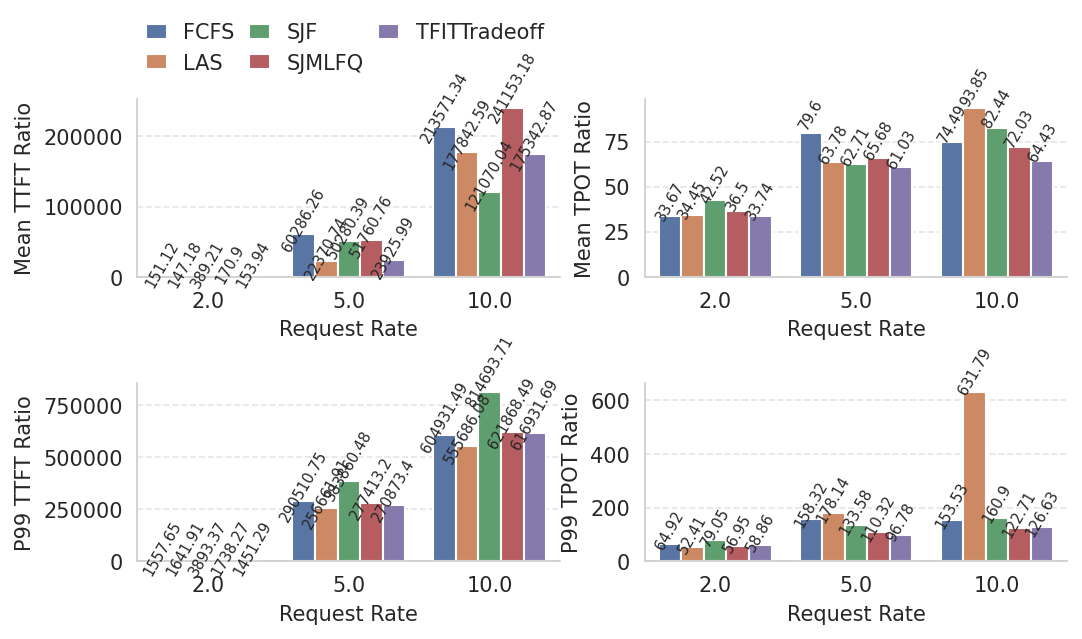

In [15]:
required_metric_name_list = ["Mean", "P99"]
required_metric_type_list = ["TTFT", "TPOT"]
plot_bar(long_df, required_metric_name_list, required_metric_type_list)

## request level result

In [16]:
def calculate_p99_itls(df):
    """计算请求级别的 P99 ITLs"""
    if "itls" in df.columns:
        df["request_level_p99_itls"] = df["itls"].apply(lambda row: np.percentile(row, 99) if len(row) > 0 else 0)
    return df

def process_request_level_data(e2e_result_dfs):
    """处理请求级别数据并返回合并后的 DataFrame"""
    # 定义需要删除的列
    columns_to_drop = [
        "model_id",
        "swap_space",
        "preemption_mode",
        "max_num_seqs",
        "swap_policy",
        "iter_theshold",
        "swap_out_partial_rate",
        "waiting_iter_base",
        "duration",
        "completed",
        "total_input_tokens",
        "total_output_tokens",
        "median_tpot_ms",
        "median_itl_ms",
        "median_lat_ms",
        "input_lens",
        "output_lens",
        "itls",
    ]

    # 处理每个 DataFrame 并合并结果
    request_level_result = pd.concat(
        [calculate_p99_itls(df.copy()).drop(columns=columns_to_drop) for df in e2e_result_dfs.values()],
        axis=0,
        ignore_index=True,
    )

    return request_level_result


request_level_result = process_request_level_data(e2e_result_dfs)

### P99 ITL

/tmp/ipykernel_806519/3905649580.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df["request_level_p99_itls"].quantile(0.99))
/tmp/ipykernel_806519/3905649580.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio_result(row,'itls_p99'))


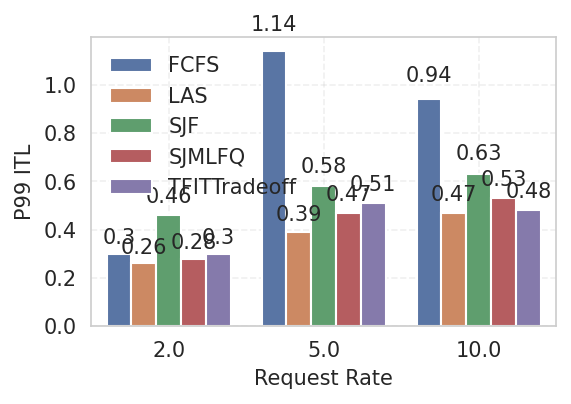

In [17]:
def calculate_p99_max(request_level_result):
    """计算请求级别的 P99 ITLs 最大值"""
    p99_max = (
        request_level_result.groupby(["scheduler_policy", "request_rate"])
        .apply(lambda df: df["request_level_p99_itls"].quantile(0.99))
        .reset_index()
    )
    p99_max.columns = ["scheduler_policy", "request_rate", "itls_p99"]
    return p99_max

def plot_p99_itls(p99_max):
    """绘制 P99 ITLs 柱状图"""
    plt.figure(figsize=(4, 2.5), dpi=150)
    ax= sns.barplot(
        data=p99_max,
        x="request_rate",
        y="itls_p99",
        hue="scheduler_policy",
    )
    add_num_annotation(ax)
    plt.legend(title="")
    plt.grid(alpha=0.3, linestyle="--")
    plt.legend(frameon=False)
    plt.xlabel("Request Rate")
    plt.ylabel("P99 ITL")
    # plt.ylim(0,2.8)
    plt.show()

p99_max = calculate_p99_max(request_level_result)
p99_max = (
    p99_max.groupby(["request_rate"], group_keys=False)
    .apply(lambda row: get_metric_ratio_result(row,'itls_p99'))
    .reset_index()
)

plot_p99_itls(p99_max)

### Median TTFT

/tmp/ipykernel_806519/3620448181.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio_result(row,"median_ttft_ms"))


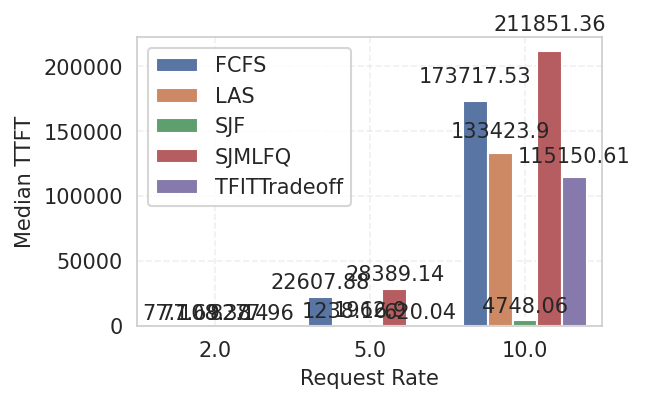

In [18]:
def calculate_median_ttft_max(request_level_result):
    """计算请求级别的中位数 TTFT 最大值"""
    median_ttft_max = (
        request_level_result.groupby(["scheduler_policy", "request_rate"])
        .agg({"median_ttft_ms": "mean"})
        .reset_index()
    )
    median_ttft_max.columns = ["scheduler_policy", "request_rate", "median_ttft_ms"]
    return median_ttft_max

def plot_median_ttft(median_ttft_max):
    """绘制中位数 TTFT 柱状图"""
    plt.figure(figsize=(4, 2.5), dpi=150)
    ax = sns.barplot(
        data=median_ttft_max,
        x="request_rate",
        y="median_ttft_ms",
        hue="scheduler_policy",
    )
    add_num_annotation(ax)
    plt.legend(title="")
    plt.grid(alpha=0.3, linestyle="--")
    plt.ylabel("Median TTFT")
    plt.xlabel("Request Rate")
    plt.show()

median_ttft_max = calculate_median_ttft_max(request_level_result)

median_ttft_max = (
    median_ttft_max.groupby(["request_rate"], group_keys=False)
    .apply(lambda row: get_metric_ratio_result(row,"median_ttft_ms"))
    .reset_index()
)

plot_median_ttft(median_ttft_max)

### Latency

/tmp/ipykernel_806519/1957851728.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda row: get_metric_ratio_result(row, "mean_lat_ms"))


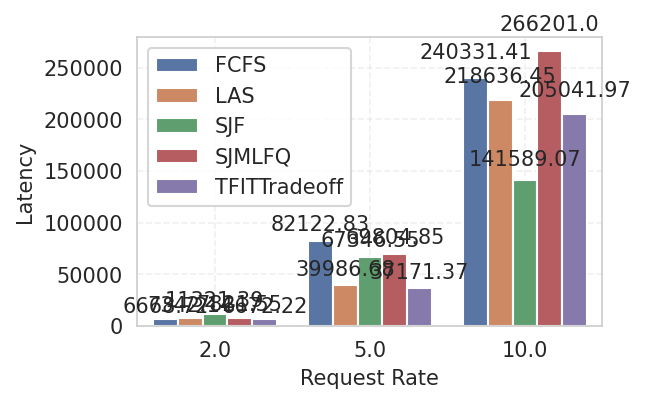

In [19]:
def calculate_latency_max(request_level_result):
    """计算请求级别的中位数 TTFT 最大值"""
    latency_max = (
        request_level_result.groupby(["scheduler_policy", "request_rate"])
        .agg({"mean_lat_ms": "mean"})
        .reset_index()
    )
    latency_max.columns = ["scheduler_policy", "request_rate", "mean_lat_ms"]
    return latency_max

def plot_latency(median_ttft_max):
    """绘制中位数 TTFT 柱状图"""
    plt.figure(figsize=(4, 2.5), dpi=150)
    ax = sns.barplot(
        data=latency_max,
        x="request_rate",
        y="mean_lat_ms",
        hue="scheduler_policy",
    )
    add_num_annotation(ax)
    plt.legend(title="")
    plt.grid(alpha=0.3, linestyle="--")
    plt.ylabel("Latency")
    plt.xlabel("Request Rate")
    plt.show()


metric='mean_lat_ms'
latency_max = calculate_latency_max(request_level_result)

latency_max = (
    latency_max.groupby(["request_rate"], group_keys=False)
    .apply(lambda row: get_metric_ratio_result(row, "mean_lat_ms"))
    .reset_index()
)

plot_latency(latency_max)

# Source of Improvement

## Runtime Analysis 

In [20]:
# dates = ["20250102","20250103"]
# dates=['20250109']
# dates=['20250110']
# dates=['20250114']
# dates=['20250116','20250117']
dates=['20250219']
# counters = [[340, 346]]
# counters=[[350],[384]]
# counters=[[479, 481]]
# counters=[[496,497]]
# counters=[[499,502]]
# counters=[[519]
# counters=[[567]]
# counters=[[592],[592]]
counters=[[812]]
qps = "20.0qps"
detailed = False
dir_names = generate_dir_names(base_dir, dates, counters)
schedule_policies = [ "las",  "fcfs", "tfittradeoff"]
execute_result_dfs = load_execute_results(dir_names, schedule_policies,qps, detailed)
policies = list(execute_result_dfs.keys())

<Axes: title={'center': 'Cache Efficiency'}, xlabel='Time', ylabel='Cache Efficiency'>

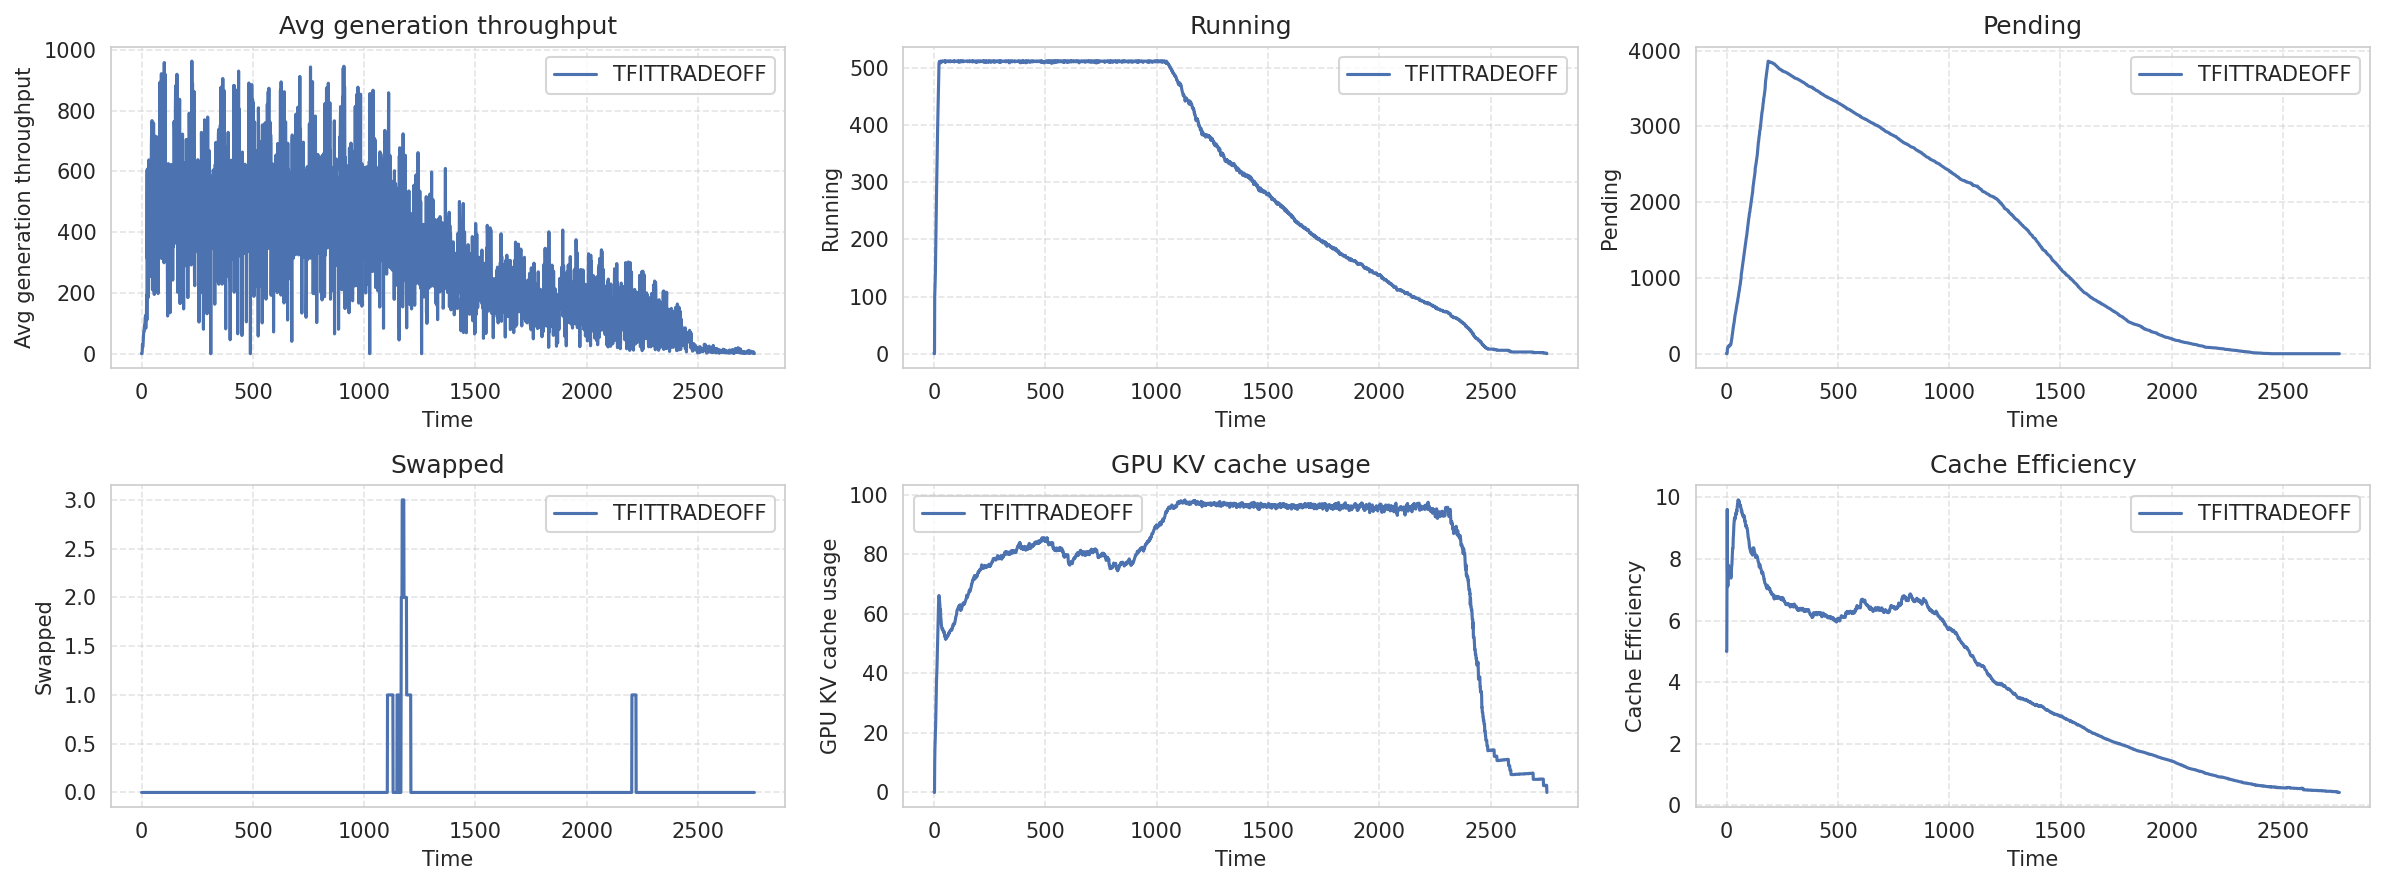

In [21]:
plt.figure(figsize=(16, 6), dpi=150)
metric_labels = ["Avg generation throughput", "Running", "Pending", "Swapped", "GPU KV cache usage", "Cache Efficiency"]


for metric_label in metric_labels:
    plt.subplot(2, 3, metric_labels.index(metric_label)+1)
    plt.title(metric_label)
    plt.grid(alpha=0.5, linestyle="--")
    for policy in policies:
        sns.lineplot(
            data=execute_result_dfs[policy],
            x=execute_result_dfs[policy].index,
            y=metric_label,
            label=policy,
        )
    plt.xlabel("Time")
plt.tight_layout()
plt.gca()

## Breakdown of the inference time

In [22]:
dates = ["20250102"]
counters = [[343]]
qps = "10.0qps"
detailed = True 
dir_names = generate_dir_names(base_dir, dates, counters)
schedule_policies = ["sjf", "las", "srjf", "fcfs", "tfittradeoff"]
execute_detailed_result_dfs= load_execute_results(dir_names, schedule_policies,qps, detailed)
policies = list(execute_detailed_result_dfs.keys())

In [23]:
execute_detailed_result_df = execute_detailed_result_dfs[policies[0]]
selected_columns = [
    "Total schedule time",
    "prefill token num",
    "decode token num",
    "swap out block num",
    "swap in block num",
    "swap time",
    "handle output time",
    "sample time",
    "single execution time",
]
selected_execute_detailed_result_df = execute_detailed_result_df[selected_columns].copy()
selected_execute_detailed_result_df[
    ["Total schedule time", "swap time", "handle output time", "swap out block num", "swap in block num"]
] = selected_execute_detailed_result_df[
    ["Total schedule time", "swap time", "handle output time", "swap out block num", "swap in block num"]
].diff()
selected_execute_detailed_result_df = selected_execute_detailed_result_df.dropna()

In [24]:
selected_execute_detailed_result_df_numeric = selected_execute_detailed_result_df.drop(
    columns=["prefill token num", "decode token num", "swap out block num", "swap in block num"]
)
selected_execute_detailed_result_df_percentage = (
    selected_execute_detailed_result_df_numeric.div(selected_execute_detailed_result_df_numeric.sum(axis=1), axis=0)
    * 100
)
selected_execute_detailed_result_df_percentage[
    ["prefill token num", "decode token num", "swap in block num", "swap out block num"]
] = selected_execute_detailed_result_df[
    ["prefill token num", "decode token num", "swap in block num", "swap out block num"]
]

<Axes: xlabel='swap time', ylabel='Proportion'>

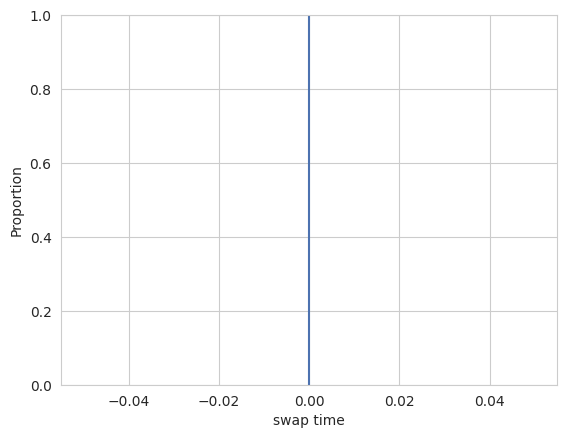

In [25]:
sns.ecdfplot(
    selected_execute_detailed_result_df_percentage[
        selected_execute_detailed_result_df_percentage["swap in block num"]
        + selected_execute_detailed_result_df_percentage["swap out block num"]
        > 0
    ].sort_values(by=["swap time"])["swap time"]
)

In [26]:
selected_execute_detailed_result_df_percentage["total swap block num"] = (
    selected_execute_detailed_result_df_percentage["swap in block num"]
    + selected_execute_detailed_result_df_percentage["swap out block num"]
)
execute_detailed_result_df_have_swap = selected_execute_detailed_result_df_percentage[
    selected_execute_detailed_result_df_percentage["total swap block num"] != 0
]

executed_detailed_result_df = execute_detailed_result_df_have_swap.melt(
    id_vars=["total swap block num"], var_name="metric", value_name="value"
)

In [27]:
executed_detailed_result_df['metric'].unique()

array(['Total schedule time', 'swap time', 'handle output time',
       'sample time', 'single execution time', 'prefill token num',
       'decode token num', 'swap in block num', 'swap out block num'],
      dtype=object)

In [28]:
metric_replace = {
    "Total schedule time":"Schedule",
    "swap time": "Swap",
    "handle output time": "Handle Output",
    "sample time": "Sample",
    "single execution time": "Execution"
}
executed_detailed_result_df = executed_detailed_result_df[executed_detailed_result_df["metric"].str.contains("time")]
executed_detailed_result_df = executed_detailed_result_df.apply(lambda x: x.replace(metric_replace, regex=True))

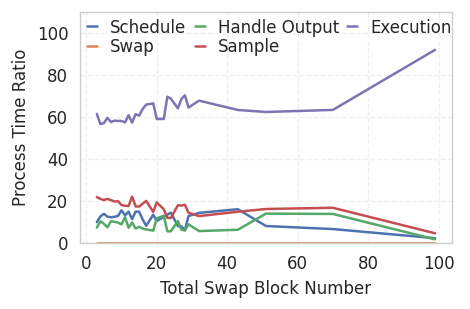

In [29]:
plt.figure(figsize=(4,2.5), dpi=120)
sns.lineplot(
    x="total swap block num",
    y="value",
    hue="metric",
    data=executed_detailed_result_df,
    errorbar=None,
)
plt.xlabel("Total Swap Block Number")
plt.ylabel("Process Time Ratio")
plt.legend(loc=(0, 0.78), frameon=False, ncol=3, handlelength=0.6, labelspacing=0.1, columnspacing=0.5)
plt.ylim(0,110)
plt.grid(True, alpha=0.3, linestyle="--")